In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf
import nfp

print(f"tensorflow {tf.__version__}")
print(f"nfp {nfp.__version__}")

tensorflow 2.8.0
nfp 0+unknown


## Loading Dataset

In [2]:
qm9 = pd.read_csv("qm9.csv")
qm9.head(10)

,mol_id,smiles,A,B,C,mu,alpha,homo,lumo,gap,...,zpve,u0,u298,h298,g298,cv,u0_atom,u298_atom,h298_atom,g298_atom
0,gdb_1,C,157.71180,157.709970,157.706990,0.0000,13.21,-0.3877,0.1171,0.5048,...,0.044749,-40.478930,-40.476062,-40.475117,-40.498597,6.469,-395.999595,-398.643290,-401.014647,-372.471772
1,gdb_2,N,293.60975,293.541110,191.393970,1.6256,9.46,-0.2570,0.0829,0.3399,...,0.034358,-56.525887,-56.523026,-56.522082,-56.544961,6.316,-276.861363,-278.620271,-280.399259,-259.338802
2,gdb_3,O,799.58812,437.903860,282.945450,1.8511,6.31,-0.2928,0.0687,0.3615,...,0.021375,-76.404702,-76.401867,-76.400922,-76.422349,6.002,-213.087624,-213.974294,-215.159658,-201.407171
3,gdb_4,C#C,0.00000,35.610036,35.610036,0.0000,16.28,-0.2845,0.0506,0.3351,...,0.026841,-77.308427,-77.305527,-77.304583,-77.327429,8.574,-385.501997,-387.237686,-389.016047,-365.800724
4,gdb_5,C#N,0.00000,44.593883,44.593883,2.8937,12.99,-0.3604,0.0191,0.3796,...,0.016601,-93.411888,-93.409370,-93.408425,-93.431246,6.278,-301.820534,-302.906752,-304.091489,-288.720028
5,gdb_6,C=O,285.48839,38.982300,34.298920,2.1089,14.18,-0.2670,-0.0406,0.2263,...,0.026603,-114.483613,-114.480746,-114.479802,-114.505268,6.413,-358.756935,-360.512706,-362.291066,-340.464421
6,gdb_7,CC,80.46225,19.906490,19.906330,0.0000,23.95,-0.3385,0.1041,0.4426,...,0.074542,-79.764152,-79.760666,-79.759722,-79.787269,10.098,-670.788296,-675.710476,-679.860821,-626.927299
7,gdb_8,CO,127.83497,24.858720,23.978720,1.5258,16.97,-0.2653,0.0784,0.3437,...,0.051208,-115.679136,-115.675816,-115.674872,-115.701876,8.751,-481.106758,-484.355372,-487.319724,-450.124128
8,gdb_9,CC#C,160.28041,8.593230,8.593210,0.7156,28.78,-0.2609,0.0613,0.3222,...,0.055410,-116.609549,-116.605550,-116.604606,-116.633775,12.482,-670.268091,-673.980434,-677.537155,-631.346845
9,gdb_10,CC#N,159.03567,9.223270,9.223240,3.8266,24.45,-0.3264,0.0376,0.3640,...,0.045286,-132.718150,-132.714563,-132.713619,-132.742149,10.287,-589.812024,-592.893721,-595.857446,-557.125708


## Remove duplicate SMILES

In [3]:
# Remove duplicates
qm9 = qm9.drop_duplicates(subset='smiles', keep="first")

## Split Dataset

In [4]:
# Following 15% validation, 15% testing, 70% training size

valid, test, train = np.split(qm9.smiles.sample(frac=1., random_state=123), [20000, 40000])
len(train), len(valid), len(test)

(93802, 20000, 20000)

## Define how to featurize the input molecules

In [5]:
from nfp.preprocessing.mol_preprocessor import SmilesPreprocessor
from nfp.preprocessing.features import get_ring_size


def atom_featurizer(atom):
    """ Return an string representing the atom type
    """

    return str((
        atom.GetSymbol(),
        atom.GetIsAromatic(),
        get_ring_size(atom, max_size=6),
        atom.GetDegree(),
        atom.GetTotalNumHs(includeNeighbors=True)
    ))


def bond_featurizer(bond, flipped=False):
    """ Get a similar classification of the bond type.
    Flipped indicates which 'direction' the bond edge is pointing. """
    
    if not flipped:
        atoms = "{}-{}".format(
            *tuple((bond.GetBeginAtom().GetSymbol(),
                    bond.GetEndAtom().GetSymbol())))
    else:
        atoms = "{}-{}".format(
            *tuple((bond.GetEndAtom().GetSymbol(),
                    bond.GetBeginAtom().GetSymbol())))
    
    btype = str(bond.GetBondType())
    ring = 'R{}'.format(get_ring_size(bond, max_size=6)) if bond.IsInRing() else ''
    
    return " ".join([atoms, btype, ring]).strip()


preprocessor = SmilesPreprocessor(atom_features=atom_featurizer, bond_features=bond_featurizer,
                                  explicit_hs=False)

In [6]:
# Initially, the preprocessor has no data on atom types, so we have to loop over the 
# training set once to pre-allocate these mappings
print("before pre-allocating")
print(preprocessor.atom_tokenizer._data)

for smiles in train:
    preprocessor(smiles, train=True)
    
print()
print("after pre-allocating")
print(preprocessor.atom_tokenizer._data)

before pre-allocating
{'unk': 1}


2022-04-07 17:50:09.819972: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.



after pre-allocating
{'unk': 1, "('C', False, 0, 1, 3)": 2, "('C', False, 0, 3, 0)": 3, "('O', False, 0, 1, 0)": 4, "('N', False, 0, 2, 1)": 5, "('C', False, 0, 2, 2)": 6, "('C', False, 3, 4, 0)": 7, "('C', False, 3, 2, 2)": 8, "('O', False, 0, 1, 1)": 9, "('C', False, 4, 4, 0)": 10, "('C', False, 4, 2, 2)": 11, "('C', False, 4, 3, 1)": 12, "('C', False, 'max', 2, 2)": 13, "('C', False, 'max', 3, 0)": 14, "('O', False, 4, 2, 0)": 15, "('N', False, 3, 2, 1)": 16, "('C', False, 0, 2, 0)": 17, "('C', False, 0, 1, 1)": 18, "('C', True, 5, 2, 1)": 19, "('N', True, 5, 2, 0)": 20, "('C', True, 5, 3, 0)": 21, "('C', True, 'max', 2, 1)": 22, "('N', True, 'max', 2, 0)": 23, "('O', True, 'max', 2, 0)": 24, "('C', False, 3, 3, 1)": 25, "('C', False, 5, 2, 2)": 26, "('O', False, 3, 2, 0)": 27, "('C', False, 5, 3, 1)": 28, "('O', False, 5, 2, 0)": 29, "('C', False, 5, 3, 0)": 30, "('N', False, 0, 3, 0)": 31, "('N', False, 0, 1, 2)": 32, "('C', False, 0, 2, 1)": 33, "('N', True, 5, 3, 0)": 34, "('O'

## Construct Tensorflow Dataset

In [7]:
# Construct the tf.data pipeline. There's a lot of specifying data types and
# expected shapes for tensorflow to pre-allocate the necessary arrays. But 
# essentially, this is responsible for calling the input constructor, batching 
# together multiple molecules, and padding the resulting molecules so that all
# molecules in the same batch have the same number of atoms (we pad with zeros,
# hence why the atom and bond types above start with 1 as the unknown class)

train_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor(row.smiles, train=False), row.h298)
             for i, row in qm9[qm9.smiles.isin(train)].iterrows()),
    output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))\
    .cache().shuffle(buffer_size=200)\
    .padded_batch(batch_size=64)\
    .prefetch(tf.data.experimental.AUTOTUNE)


valid_dataset = tf.data.Dataset.from_generator(
    lambda: ((preprocessor(row.smiles, train=False), row.h298)
             for i, row in qm9[qm9.smiles.isin(valid)].iterrows()),
    output_signature=(preprocessor.output_signature, tf.TensorSpec((), dtype=tf.float32)))\
    .cache()\
    .padded_batch(batch_size=64)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [8]:
inputs, outputs = next(train_dataset.as_numpy_iterator())
inputs['atom']

2022-04-07 17:53:14.808968: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


array([[22, 22, 22, 23, 22, 22],
       [ 2,  3,  4, 32,  0,  0],
       [22, 22, 23, 22, 22, 23],
       [ 2, 43,  9,  6,  6,  9],
       [11, 12, 11, 12, 11,  0],
       [ 6,  6,  9, 33,  4,  0],
       [ 2,  3, 54,  9,  6,  9],
       [ 2, 45,  2, 17, 37,  9],
       [ 2,  5, 33,  4,  0,  0],
       [26, 26, 26, 26, 26,  0],
       [ 4, 33, 25,  8, 16,  0],
       [26, 26, 29, 42, 59,  0],
       [ 6, 17, 37, 32,  0,  0],
       [ 6, 33,  4,  3,  4, 32],
       [11, 11, 49, 41,  4,  0],
       [ 2,  6, 17, 17,  2,  0],
       [19, 21, 20, 19, 44,  9],
       [ 3,  4, 32, 32,  0,  0],
       [ 2,  3,  4,  2,  0,  0],
       [ 2, 54, 33, 35,  2,  0],
       [ 2, 10, 11, 11, 15,  2],
       [ 2, 35, 25,  8,  8,  0],
       [33,  4, 32,  0,  0,  0],
       [ 2, 38,  8,  8,  0,  0],
       [19, 19, 19, 53, 19,  0],
       [19, 19, 20, 20, 53,  0],
       [ 2, 43,  2,  6,  6,  9],
       [19, 19, 20, 21, 53,  9],
       [ 2, 45,  2, 33,  4,  9],
       [ 8,  8, 25, 33,  4,  0],
       [ 2

## Creating and Training

In [9]:
## Define the keras model
from tensorflow.keras import layers

# Input layers
atom = layers.Input(shape=[None], dtype=tf.int64, name='atom')
bond = layers.Input(shape=[None], dtype=tf.int64, name='bond')
connectivity = layers.Input(shape=[None, 2], dtype=tf.int64, name='connectivity')

num_features = 8  # Controls the size of the model

# Convert from a single integer defining the atom state to a vector
# of weights associated with that class
atom_state = layers.Embedding(preprocessor.atom_classes, num_features,
                              name='atom_embedding', mask_zero=True)(atom)

# Ditto with the bond state
bond_state = layers.Embedding(preprocessor.bond_classes, num_features,
                              name='bond_embedding', mask_zero=True)(bond)

# Here we use our first nfp layer. This is an attention layer that looks at
# the atom and bond states and reduces them to a single, graph-level vector. 
# mum_heads * units has to be the same dimension as the atom / bond dimension
global_state = nfp.GlobalUpdate(units=8, num_heads=1)([atom_state, bond_state, connectivity])

for _ in range(3):  # Do the message passing
    new_bond_state = nfp.EdgeUpdate()([atom_state, bond_state, connectivity, global_state])
    bond_state = layers.Add()([bond_state, new_bond_state])
    
    new_atom_state = nfp.NodeUpdate()([atom_state, bond_state, connectivity, global_state])
    atom_state = layers.Add()([atom_state, new_atom_state])
    
    new_global_state = nfp.GlobalUpdate(units=8, num_heads=1)(
        [atom_state, bond_state, connectivity, global_state]) 
    global_state = layers.Add()([global_state, new_global_state])

    
# Since the final prediction is a single, molecule-level property, we 
# reduce the last global state to a single prediction.
bde_prediction = layers.Dense(1)(global_state)

# Construct the tf.keras model
model = tf.keras.Model([atom, bond, connectivity], [bde_prediction])

In [10]:
model.compile(loss='mae', optimizer=tf.keras.optimizers.Adam(1E-3))

# Fit the model. The first epoch is slower, since it needs to cache
# the preprocessed molecule inputs
model.fit(train_dataset, validation_data=valid_dataset, epochs=25)

Epoch 1/25
1466/1466 [==============================] - 386s 251ms/step - loss: 22.1913 - val_loss: 64.5213
Epoch 2/25
1466/1466 [==============================] - 33s 22ms/step - loss: 6.8048 - val_loss: 14.6328
Epoch 3/25
1466/1466 [==============================] - 34s 23ms/step - loss: 5.4704 - val_loss: 18.0660
Epoch 4/25
1466/1466 [==============================] - 34s 23ms/step - loss: 5.1017 - val_loss: 15.9943
Epoch 5/25
1466/1466 [==============================] - 34s 23ms/step - loss: 4.4855 - val_loss: 12.0026
Epoch 6/25
1466/1466 [==============================] - 37s 25ms/step - loss: 4.5121 - val_loss: 13.9641
Epoch 7/25
1466/1466 [==============================] - 34s 23ms/step - loss: 4.4638 - val_loss: 13.4099
Epoch 8/25
1466/1466 [==============================] - 35s 24ms/step - loss: 4.2392 - val_loss: 12.6418
Epoch 9/25
1466/1466 [==============================] - 30s 21ms/step - loss: 4.1768 - val_loss: 13.2923
Epoch 10/25
1466/1466 [=============================

## Evaluating the model

In [11]:
# Here, we create a test dataset that doesn't assume we know the values for the bde

test_dataset = tf.data.Dataset.from_generator(
    lambda: (preprocessor(smiles, train=False)
             for smiles in test),
    output_signature=preprocessor.output_signature)\
    .padded_batch(batch_size=64)\
    .prefetch(tf.data.experimental.AUTOTUNE)

In [12]:
# Here are the predictions on the test set
test_predictions = model.predict(test_dataset)
test_bde_values = qm9.loc[qm9['smiles'].isin(test)].h298

In [24]:
errors = test_bde_values - test_predictions.flatten()

# MAE
MAE = np.abs(errors).mean()
MAE

41.86142753049204

In [25]:
# RMSE
from sklearn.metrics import mean_squared_error
RMSE = mean_squared_error(test_bde_values, test_predictions.flatten(), squared=False)
RMSE

53.80228300416894

In [26]:
# “reduce values” = RMSE/std dev of target data
reduce_values = RMSE / (qm9['h298'].std())
reduce_values

1.343173485271052

In [27]:
# MAE/MAD
MAE / (qm9['h298'].mad())

1.3469518000927045

In [15]:
# MIN
min(errors)

-241.33612742089844

In [16]:
# MAX
max(errors)

304.1858575234375

(array([1.700e+01, 8.700e+01, 7.960e+02, 4.680e+03, 8.084e+03, 4.976e+03,
        1.128e+03, 1.980e+02, 2.800e+01, 6.000e+00]),
 array([-241.33612742, -186.78392893, -132.23173043,  -77.67953194,
         -23.12733344,   31.42486505,   85.97706355,  140.52926204,
         195.08146053,  249.63365903,  304.18585752]),
 <BarContainer object of 10 artists>)

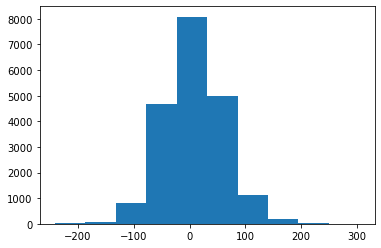

In [17]:
# Histogram of errors
import matplotlib.pyplot as plt
plt.hist(errors, bins=10)

Text(0.5, 1.0, 'Residual v.s Predicted Value')

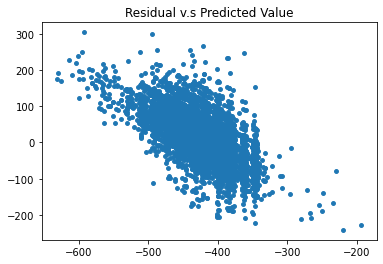

In [18]:
# Residual v.s Predicted Value
plt.scatter(test_predictions.flatten(), errors, s=15);
plt.title("Residual v.s Predicted Value")